In [85]:
import numpy as np
import nltk
import re
import pandas as pd 
import json
import os
import pickle
import csv
import matplotlib.pyplot as plt

from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
from stop_words import get_stop_words
from string import punctuation

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial

from ast import literal_eval

from urllib.parse import urlparse

nltk.download('words')
th_stop = thai_stopwords()
en_stop = get_stop_words('en')
p_stemmer = PorterStemmer()

dup_check = []

def split_word(text):
    tokens = word_tokenize(text,engine='newmm')
    
    # Remove stop words ภาษาไทย และอักขระพิเศษ
    tokens = [i for i in tokens if (not i in th_stop) & (not i in en_stop) & (not i in punctuation) & (not i in ["'",'"','“','”','‘','’','\n',"None", ' '])] 
    
    # ลบตัวเลข
    tokens = [i for i in tokens if not i.isnumeric()]
    
    # ลบช่องว่าง
    tokens = [i for i in tokens if not ' ' in i]

    return tokens

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## ดึงข้อมูลของ cofact

### ดึงส่วนอ้างอิงของ cofact

In [86]:
def read_cofact_refer(): #สำหรับดึงข้อมูลของ cofact csv
    global dup_check
    
    # Opening CSV file
    root_path = os.getcwd()
    path = os.path.join(root_path, '../result/Cofact/old/cofact_refer_old.csv')
    
    f = open(path, encoding="utf8")
    
    # returns CSV object as
    # a dictionary
    csvreader = csv.reader(f)

    # read header from CSV file
    header = []
    header = next(csvreader)
    
    rows = []
    
    for row in csvreader:
        tmp = []
        
        content_parts = []
        content = ''
        
        # เพิ่ม header + content และตรวจสอบว่า header ซ้ำหรือไม่
        if row[1] in dup_check:
            continue
        
        elif row[1] not in dup_check:
            dup_check.append(row[1])
            content_parts = literal_eval(row[2])
            content = ''.join(filter(None, content_parts))
            tmp.append(row[1] + content) 

        # เพิ่ม content
        content_parts = literal_eval(row[2])
        content = ''.join(filter(None, content_parts))
        
        tmp.append(content)
        
        # เพิ่ม link (ข่าวต้นทางสุด)
        tmp.append(row[3])
        
        # เพิ่ม link (ลิงค์บนเว็บไซต์ cofact)
        tmp.append(row[5])
        
        # เพิ่ม header
        tmp.append(row[1])
        
        rows.append(tmp)

    # Closing file
    f.close()
    
    return rows

In [87]:
cofact_refer_text_list = read_cofact_refer()

In [88]:
len(cofact_refer_text_list)

2050

### ดึงส่วนคนถามของ cofact

In [89]:
def read_cofact_info(): #สำหรับดึงข้อมูลของ cofact info csv
    # Opening CSV file
    root_path = os.getcwd()
    path = os.path.join(root_path, '../result/Cofact/old/cofact_info_old.csv')
    
    f = open(path, encoding="utf8")
    
    # returns CSV object as
    # a dictionary
    csvreader = csv.reader(f)

    # read header from CSV file
    header = []
    header = next(csvreader)
    
    rows = []
    info_dup_check = []
    
    for row in csvreader:
        tmp = []
        
        content_parts = []
        content = ''
        # เพิ่ม ส่วนที่คนถาม (query) + ตรวจสอบว่า query ซ้ำหรือไม่
        if row[1] in info_dup_check:
            continue
        
        elif row[1] not in info_dup_check:
            info_dup_check.append(row[1])
            tmp.append(row[1])

        # เพิ่ม link (ลิงค์บนเว็บไซต์ cofact)
        tmp.append(row[3]) 
        
        rows.append(tmp)

    # Closing file
    f.close()
    
    return rows

In [90]:
cofact_info_text_list = read_cofact_info()

In [91]:
len(cofact_info_text_list)

3547

In [92]:
matched_list = []

for i in range(len(cofact_refer_text_list)):
    for j in range(len(cofact_info_text_list)):
        tmp = []
        if cofact_info_text_list[j][1] == cofact_refer_text_list[i][3]:
            tmp.append(cofact_info_text_list[j][0])
            tmp.append(cofact_refer_text_list[i][0])
            matched_list.append(tmp)

In [93]:
len(matched_list)

1704

### นำ query ซ้ำใน matched list ออก

In [94]:
matched_list_dup_check = []
dup_del_matched_list = []

for query in matched_list:
    if query[0] in matched_list_dup_check:
        continue
    elif query[0] not in matched_list:
        matched_list_dup_check.append(query[0])
        dup_del_matched_list.append(query)

In [95]:
len(dup_del_matched_list)

1611

## ดึงส่วนอ้างอิงของ anti-fake news

In [96]:
def read_anti_refer(): #สำหรับดึงข้อมูลของ anti fake news csv
    global dup_check
    
    # Opening CSV file
    root_path = os.getcwd()
    path = os.path.join(root_path, '../result/Anti/anti_info.csv')
    f = open(path, encoding="utf8")
    
    # returns CSV object as
    # a dictionary
    csvreader = csv.reader(f)
    
    # read header from CSV file
    header = []
    header = next(csvreader)

    rows = []
    
    for row in csvreader:
        tmp = []
        
        content_parts = []
        content = ''
        
        # เพิ่ม header + content และตรวจสอบว่า header ซ้ำหรือไม่
        if row[1] in dup_check:
            continue
        
        elif row[1] not in dup_check:
            dup_check.append(row[1])
            tmp.append(row[1] + row[2]) 
        
        # เพิ่ม content
        tmp.append(row[2])
        
        # เพิ่ม link
        tmp.append(row[3])
        
        # เพิ่ม datetime
        tmp.append(row[5])
        
        # เพิ่ม header
        tmp.append(row[1])
        
        rows.append(tmp)

    # Closing file
    f.close()
    
    return rows

In [97]:
anti_refer_text_list = read_anti_refer()

## ดึงส่วนอ้างอิงของ sure and share

In [98]:
def read_sure_refer(): #สำหรับดึงข้อมูลของ sure and share csv
    global dup_check
    
    # Opening CSV file
    root_path = os.getcwd()
    path = os.path.join(root_path, '../result/Sure/sure_info.csv')
    f = open(path, encoding="utf8")
    
    # returns CSV object as
    # a dictionary
    csvreader = csv.reader(f)
    
    # read header from CSV file
    header = []
    header = next(csvreader)

    rows = []
    
    for row in csvreader:
        tmp = []
        
        content_parts = []
        content = ''
        
        # เพิ่ม header + content และตรวจสอบว่า header ซ้ำหรือไม่
        if row[1] in dup_check:
            continue
        
        elif row[1] not in dup_check:
            dup_check.append(row[1])
            tmp.append(row[1] + row[2]) 
        
        # เพิ่ม content
        tmp.append(row[2])
        
        # เพิ่ม link
        tmp.append(row[3])
        
        # เพิ่ม datetime
        tmp.append(row[5])
        
        # เพิ่ม header
        tmp.append(row[1])
        
        rows.append(tmp)

    # Closing file
    f.close()
    
    return rows

In [99]:
sure_refer_text_list = read_sure_refer()

In [100]:
all_refer_text_list = []
all_refer_text_list = cofact_refer_text_list # + anti_refer_text_list + sure_refer_text_list

In [101]:
len(all_refer_text_list)

2050

## ------------------------------------------------------------------------------
## สร้าง dataframe ของ cofact สำหรับอ้างถึงตอนแนบลิงค์ url แสดงผล

In [102]:
all_refer_header_and_content = []
all_refer_content = []
all_refer_url = []
all_refer_datetime = []
all_refer_domain = []
all_refer_header = []

for i in range(len(all_refer_text_list)):
    all_refer_header_and_content.append(all_refer_text_list[i][0]) #list ของส่วนหัวข้อข่าว + เนื้อหา
    all_refer_content.append(all_refer_text_list[i][1]) #list ของส่วนเนื้อหาเท่านั้น
    all_refer_url.append(all_refer_text_list[i][2]) #list ของ url เท่านั้น
    all_refer_datetime.append(all_refer_text_list[i][3]) #list ของ datetime เท่านั้น
    all_refer_domain.append(urlparse(all_refer_text_list[i][2]).hostname) #list ของ domain เท่านั้น
    all_refer_header.append(all_refer_text_list[i][4]) #list ของส่วนหัวข้อข่าวเท่านั้น


In [103]:
#ทำ list ให้เป็น dataframe
all_original_text_and_headline_news_df = pd.DataFrame(list(zip(all_refer_header_and_content, all_refer_content, all_refer_url, all_refer_datetime, all_refer_domain, all_refer_header)), columns=["All_headline_and_content_from_every_reference", "All_content_from_every_reference", "All_URL_from_every_reference", "All_datatime_from_every_reference", "All_domain_from_every_reference", "All_headline_from_every_reference"])

all_original_text_and_headline_news_df

All_headline_and_content_from_every_reference  \
0     น้ำชาไม่สามารถรักษาโรคแพ้อาหารได้ โปรดอย่าหลงเ...   
1     มะนาวเกลือแก้ไมเกรน มั่วมาก อย่าไปเชื่อเอาอีกแ...   
2     อย่าหลงเชื่อ “นาโน สเปรย์” อ้างฆ่าเชื้อไวรัสแล...   
3     ดื่มกาแฟวันละสามแก้วทำให้หน้าอกเล็กลงไม่จริง ก...   
4     คิ้วดกดำด้วยการทาปิโตรเลียม เจลลี่ ไม่จริงแชร์...   
...                                                 ...   
2045  โควิด-19 : นมตราหมี ยาฆ่าพยาธิ และน้ำมันหอมระเ...   
2046  โควิด : WHO ให้ชื่อ "โอไมครอน" สายพันธุ์ใหม่ที...   
2047  ยูเอ็นเปิดผลศึกษาคดีข่มขืนในไทย-เวียดนาม ผู้หญ...   
2048  WHO : อุบัติเหตุบนท้องถนนทำให้คนหนุ่มสาวเสียชี...   
2049  ศูนย์จีโนมฯ ระบุโควิด- 19 ใกล้ End game กลายเป...   

                       All_content_from_every_reference  \
0     มีการแชร์ให้เห็นอยู่บ่อยว่า มีน้ำชาดื่มแล้วรัก...   
1     เอาอีกแล้ว ไม่เช็คให้ชัวร์ แล้วก็แชร์กันไปมั่ว...   
2     อย. เตือน!! อย่าหลงเชื่อผลิตภัณฑ์ NANO SILVER ...   
3     กาแฟเป็นเครื่องดื่มที่นิยมอย่างแพร่หลายทั่วโลก...   
4     แชร์ทั่วอินเทอร์เน็ตว่า มีคนนำปิโตรเลียม เจลลี...   
...                                                 ...   
2045  โรงพยาบาลต่าง ๆ กำลังประสบปัญหาคนไข้ล้น และการ...   
2046  WHO แถลงเมื่อวันที่ 26 พ.ย. ว่าเชื้อนี้มีการกล...   
2047  องค์การเพื่อการส่งเสริมความเสมอภาคระหว่างเพศแล...   
2048  WHO เผยแพร่ตัวเลขที่ชี้ให้เห็นว่าทวีปแอฟริกามี...   
2049  ศูนย์จีโนมทางการแพทย์ คณะแพทย์ศาสตร์ โรงพยาบาล...   

                           All_URL_from_every_reference  \
0     https://sure.oryor.com/index.php/detail/media_...   
1     https://sure.oryor.com/index.php/detail/media_...   
2     https://oryor.com/%E0%B8%AD%E0%B8%A2/detail/me...   
3     https://sure.oryor.com/index.php/detail/media_...   
4     https://sure.oryor.com/index.php/detail/media_...   
...                                                 ...   
2045    https://www.bbc.com/thai/international-57901266   
2046    https://www.bbc.com/thai/international-59428316   
2047         https://www.bbc.com/thai/thailand-42170733   
2048    https://www.bbc.com/thai/international-46545106   
2049          https://news.thaipbs.or.th/content/311692   

             All_datatime_from_every_reference  \
0     https://cofact.org/article/18fondmkdx5t1   
1      https://cofact.org/article/rzoplz5v22rb   
2     https://cofact.org/article/110yfgvyqqj5d   
3     https://cofact.org/article/2wmt8eex5xqcg   
4     https://cofact.org/article/288f0qlim28fh   
...                                        ...   
2045  https://cofact.org/article/1zctvpcnaf09t   
2046   https://cofact.org/article/lbsaldkysx4t   
2047  https://cofact.org/article/1r33jgmldh36l   
2048   https://cofact.org/article/7pxib0bvohpq   
2049  https://cofact.org/article/1wia7tfbojy4q   

     All_domain_from_every_reference  \
0                     sure.oryor.com   
1                     sure.oryor.com   
2                          oryor.com   
3                     sure.oryor.com   
4                     sure.oryor.com   
...                              ...   
2045                     www.bbc.com   
2046                     www.bbc.com   
2047                     www.bbc.com   
2048                     www.bbc.com   
2049              news.thaipbs.or.th   

                      All_headline_from_every_reference  
0     น้ำชาไม่สามารถรักษาโรคแพ้อาหารได้ โปรดอย่าหลงเ...  
1               มะนาวเกลือแก้ไมเกรน มั่วมาก อย่าไปเชื่อ  
2     อย่าหลงเชื่อ “นาโน สเปรย์” อ้างฆ่าเชื้อไวรัสแล...  
3         ดื่มกาแฟวันละสามแก้วทำให้หน้าอกเล็กลงไม่จริง   
4            คิ้วดกดำด้วยการทาปิโตรเลียม เจลลี่ ไม่จริง  
...                                                 ...  
2045  โควิด-19 : นมตราหมี ยาฆ่าพยาธิ และน้ำมันหอมระเ...  
2046  โควิด : WHO ให้ชื่อ "โอไมครอน" สายพันธุ์ใหม่ที...  
2047  ยูเอ็นเปิดผลศึกษาคดีข่มขืนในไทย-เวียดนาม ผู้หญ...  
2048  WHO : อุบัติเหตุบนท้องถนนทำให้คนหนุ่มสาวเสียชี...  
2049  ศูนย์จีโนมฯ ระบุโควิด- 19 ใกล้ End game กลายเป...  

[2050 rows x 6 columns]

In [104]:
all_headline_and_content_tokens_list = [split_word(txt) for txt in all_refer_header_and_content] #นำ list ของหัวข้อข่าวมาตัดคำ

In [105]:
all_tokens_list_j = [','.join(tkn) for tkn in all_headline_and_content_tokens_list]

----------------------------------------------------------------------------------
# สร้าง vocabulary set

In [106]:
print(all_tokens_list_j[0].split(",")[0:2])


['น้ำชา', 'รักษาโรค']


In [107]:
## Create Vocabulary
tokens_list = []

for words in all_tokens_list_j:
    # print(words)
    temp_list = words.split(",")
    # print(temp_list)
    for i in temp_list:
        tokens_list.append(i)

vocabulary = set(tokens_list)
vocabulary = list(vocabulary)

In [108]:
len(vocabulary)

19290

--------------------------------------------------------------------------------------

In [109]:
tvec = TfidfVectorizer(analyzer=lambda x:x.split(','),)
original_c_feat = tvec.fit_transform(all_tokens_list_j)

### Save Trained TFID Model

In [110]:
### Save model
root_path = os.getcwd()
path = os.path.join(root_path, 'all-tfid.pkl')
print(path)
with open(path,'wb') as handle:
    pickle.dump(original_c_feat, handle)

c:\Users\Administrator\Documents\SeniorProject\Senior-project\Preprocess\all-tfid.pkl


In [111]:
### load model
root_path = os.getcwd()
path = os.path.join(root_path, 'all-tfid.pkl')
print(path)
t = pickle.load(open(path,'rb'))

c:\Users\Administrator\Documents\SeniorProject\Senior-project\Preprocess\all-tfid.pkl


### Save Vocabulary

In [112]:
### Save Vacabulary
root_path = os.getcwd()
path = os.path.join(root_path, 'vocabulary_all.txt')
print(path)
with open(path, "w", encoding="utf-8") as file:
    file.write(str(vocabulary))

c:\Users\Administrator\Documents\SeniorProject\Senior-project\Preprocess\vocabulary_all.txt


In [113]:
### load Vacabulary
root_path = os.getcwd()
path = os.path.join(root_path, 'vocabulary_all.txt')
print(path)
with open(path, "r", encoding="utf-8") as file:
    data2 = eval(file.readline())

c:\Users\Administrator\Documents\SeniorProject\Senior-project\Preprocess\vocabulary_all.txt


In [114]:
data2

['',
 'คุ้มครอง',
 '\xa0\xa0"จนผม',
 'ควบคุมตัว',
 'หลายอย่าง',
 '(ศบค.มท.)',
 'บานพับ',
 'ทั้งคืน',
 '590',
 'ทะเบียนบ้าน',
 'สคบ.',
 'ขยายภาพ',
 'dcy',
 'Benzyl',
 'วิทยาเขต',
 'สำรวจหา',
 'พงษ์',
 'จริยธรรม',
 'รับเงิน',
 'ผู้สั่ง',
 'บารมี',
 'Eurasian',
 'ช์',
 'แปรไข้',
 'ตั้งเป้า',
 'คะน้า',
 'เจ้าพระยา',
 'อัณฑะ',
 'ปัญ',
 'แก้ว',
 'ศก.',
 'Public',
 'ะคน',
 'เหงา',
 'อนวัช',
 '๓.',
 'ค่าธรรมเนียม',
 'หลายใจ',
 'กระเพาะอาหาร',
 'อานันท์',
 'พญารากดำ',
 'ฝั่งคลอง',
 'spike',
 'Typhimurium',
 'หล่ม',
 'ค้นหา',
 'โครงสร้าง',
 'ระบบประสาท',
 'ตลาด',
 'รับโทรศัพท์',
 'ณะ',
 'VACCINE',
 'กระถิน',
 'ซีก',
 'เรื่องราว',
 'รัตนากร',
 'e-KYC',
 'Height',
 'COV',
 'Light',
 'สมฤดี',
 'Finance',
 'มีมูลความจริง',
 'ทะ',
 'Preservatives',
 'ธานี',
 'ข้ามถนน',
 '97.26',
 'epidemiology',
 'ความกตัญญู',
 'ฟางข้าว',
 'เพิ่มมากขึ้น',
 'เสด็จ',
 'สุขภาวะ',
 'หายใจออก',
 'บาทวิถี',
 'Add',
 'new',
 'ภาคฤดูร้อน',
 'อปท.',
 'โบกขรณี',
 'กระท้อน',
 'ศิรามพุช',
 'ศิก',
 'เห็นชัด',
 'ห้ามไม่ให้',
 'เรื

In [115]:
len(data2)

19290

## Create vector for Query/search keywords

In [116]:
## Create vector for Query/search keywords
def gen_vector_T(tokens):

    Q = np.zeros((len(vocabulary)))
    
    x = tvec.transform(tokens)
    
    x = x.A[0]
    return x

### Calculate Cosine similarity of trained Tfidf to input query


In [117]:
norm_original_c_feat = normalize(original_c_feat)
norm_original_c_feat = norm_original_c_feat.toarray()
norm_original_c_feat = norm_original_c_feat.T

In [118]:
query_vector = []
def cosine_similarity_T(k, query):
    tokens = split_word(str(query))
    q_df = pd.DataFrame(columns=['q_clean'])
    q_df.loc[0,'q_clean'] =str(tokens)

    q_df=q_df.replace(to_replace ="\[.", value = '', regex = True)
    q_df=q_df.replace(to_replace ="'", value = '', regex = True)
    q_df=q_df.replace(to_replace =" ", value = '', regex = True)
    q_df=q_df.replace(to_replace ='\]', value = '', regex = True)
    
    d_cosines = []
    
    query_vector = gen_vector_T(q_df['q_clean'])
    query_vector = query_vector.reshape((1,-1))

    d_cosines = np.dot(normalize(query_vector),norm_original_c_feat)
    
    list_d_cosines = d_cosines[0].tolist()
    
    out = np.array(list_d_cosines).argsort()[-k:][::-1]

    list_d_cosines.sort()
    a = pd.DataFrame()
    for i in out:
        a.loc[i,'index'] = str(i)
        a.loc[i,'headline_and_content'] = all_original_text_and_headline_news_df["All_headline_and_content_from_every_reference"][i]

    list_d_cosines.sort(reverse=True)
    
    for j in range(k):
        a.loc[out[j],'Score'] = list_d_cosines[j]
        
    return a

In [119]:
query = "สิ้นเดือนนี้ คิงส์พาวเวอร์ ปิดทุกสาขา ไม่มีกำหนด ยกเว้นสนามบิน สำนักงานใหญ่ซอยรางน้ำ ในยามปกติ ขายได้วันละ 50 ล้านบาท ตอนนี้ทุกวันขายได้วันละ 20,000 บาท"

In [120]:
%time all_result = cosine_similarity_T(30, query)

Wall time: 101 ms


In [121]:
all_result

index                               headline_and_content     Score
1310  1310    ข่าวปลอม คิงเพาเวอร์ ปิดทุกสาขาสิ้นเดือนนี้ \n   0.334849
1311  1311  “คิง เพาเวอร์” แจงข้อความว่อน “ปิดทุกสาขา” ข่า...  0.289448
1693  1693  ครม.มีมติจ่ายเงินเยียวยา "ฟรีแลนซ์" ม.39-40 คน...  0.168565
72      72  ใครบ้าง เข้าเกณฑ์ได้รับเงิน "เราไม่ทิ้งกัน" จา...  0.158405
1019  1019  เริ่มแล้ว สมอ.ควบคุมผลิต-จำหน่าย “พาวเวอร์แบงก...  0.151636
452    452  เปิดได้แล้ว! ซอยบางลา หาดป่าตอง ผับ บาร์รอ ศบค...  0.142332
1629  1629  ข่าวปลอม! นายกฯ อนุมัติ ได้คนละ 10,000 บาท ทุก...  0.135528
1444  1444  เช็ก! จังหวัดไหนบ้าง ไม่ใส่หน้ากากออกจากบ้าน ป...  0.132041
280    280  ครม.ไฟเขียวจ่าย "เยียวยากลุ่มเปราะบาง" 13ล้านค...  0.131286
1196  1196   ย้ำอีกรอบ บัตรสวัสดิการแห่งรัฐ เงินเยียวยา "เ...  0.129658
1642  1642  คกก.โรคติดต่อฯ เห็นชอบระยะห่างฉีด "แอสตราเซเนก...  0.124783
1280  1280   www.ม33เรารักกัน.com ประกันสังคมปรับเว็บไซต์ล...  0.122179
1061  1061  สธ.ประกาศห้ามขายเครื่องดื่มแอลกอฮอล์ออนไลน์ ดี...  0.119042
98      98  เตือน!อย่าหลงเชื่อข่าว เพิ่มเงินผู้รับบำนาญตาม...  0.116533
1818  1818  ข่าวปลอมรัฐแจก 25,000 บาท ชาวน่านแห่ลงทะเบียนโ...  0.116131
1963  1963  ครม. อนุมัติงบ 2.7 หมื่นล้าน ประกันรายได้และรั...  0.115409
1122  1122  ททท. สั่งชะลอเพิ่มสิทธิห้องพัก เราเที่ยวด้วยกั...  0.111790
1541  1541  คลัง กู้เพิ่ม7แสนล้านบาท สู้โควิดกระทรวงการคลั...  0.110428
555    555  เงินเข้าวันนี้ เยียวยา กลุ่มเปราะบาง รับครั้งเ...  0.109414
846    846  "คนละครึ่ง" เตรียมพร้อมให้รับสิทธิ์เงิน 3,000 ...  0.108733
843    843  ไฟเขียว "คนละครึ่ง-เพิ่มวงเงินบัตรคนจน" 29 ก.ย...  0.106710
202    202  เตือนระวังมิจฉาชีพ หลอกขาย'ตั๋วออนไลน์'ช่วงโควิด!  0.104718
177    177  อย. เตือนระวังถูกหลอก ขายแผ่นป้าย-อุปกรณ์ป้องก...  0.104034
86      86  เพิ่มเงินบำนาญ-ขยายเพดานเงินบำเหน็จ ไม่เป็นควา...  0.098328
901    901  เริ่มแล้ววันนี้! ลงทะเบียน คนละครึ่ง รับสิทธิเ...  0.097764
214    214  อย. เตือนอย่าหลงเชื่อโฆษณารับซื้อยา ส่งผลเสียท...  0.096666
1873  1873  ด่วน ครม.เคาะจ่ายเยียวยาประกันสังคม ม.33 สีแดง...  0.095858
241    241  เช็กด่วน "เยียวยานักกีฬา" กลุ่มไหนได้สิทธิ์รับ...  0.094473
389    389  ผงะ “เที่ยวปันสุข” แห่จองโดเมนเปิดเว็บ รับแจกเ...  0.093728
603    603  ธ.ออมสิน ปล่อยเงินกู้ฉุกเฉิน 5 หมื่นบาท ดอกเบี...  0.092498

In [122]:
all_result.iloc[1]['headline_and_content']

'“คิง เพาเวอร์” แจงข้อความว่อน “ปิดทุกสาขา” ข่าวเท็จ! รางน้ำ-พัทยา-ภูเก็ตเปิดตามปกติวันนี้ (16 มี.ค.) จากกรณีที่ในโซเชียลมีเดียมีการเผยแพร่และส่งต่อข้อความ ระบุว่าสิ้นเดือนนี้ คิงเพาเวอร์ ปิดทุกสาขาไม่มีกำหนด ยกเว้นสนามบิน และอ้างว่าเรียกเจ้าของรถบัส รถตู้ทุกแห่งมาคุยขอยกเลิกสัญญาไม่มีกำหนด ล่าสุด ทวิตเตอร์ KingPowerOfficial (@KingPowerhq) ระบุว่า “ข้อความส่งต่อดังกล่าวเป็นข่าวเท็จ”ทั้งนี้ เมื่อวันที่ 14 มี.ค. คิง เพาเวอร์ ปรับเปลี่ยนช่วงเวลาการให้บริการ โดย คิง เพาเวอร์ รางน้ำ และไทย เทสต์ ฮับ เปิดเวลา 10.00-20.00 น. ห้องอาหารลามูนปิดให้บริการ, คิง เพาเวอร์ พัทยา เปิดเวลา 12.00-19.00 น. ภัตตาคารรามายานะปิดให้บริการ, คิง เพาเวอร์ ภูเก็ต เปิดเวลา 11.00-19.00 น. ภัตตาคารรามายานะ เปิดให้บริการ 2 รอบ ได้แก่ 11.00-14.00 น. และ 16.00-18.00 น.ส่วนผู้ที่มีความประสงค์จะใช้บริการที่ คิง เพาเวอร์ ศรีวารี สามารถเลือกใช้บริการที่ คิง เพาเวอร์ รางน้ำ แทนได้ ในช่วงระยะเวลาดังกล่าว'

In [123]:
all_result.iloc[:10]['headline_and_content']

1310      ข่าวปลอม คิงเพาเวอร์ ปิดทุกสาขาสิ้นเดือนนี้ \n 
1311    “คิง เพาเวอร์” แจงข้อความว่อน “ปิดทุกสาขา” ข่า...
1693    ครม.มีมติจ่ายเงินเยียวยา "ฟรีแลนซ์" ม.39-40 คน...
72      ใครบ้าง เข้าเกณฑ์ได้รับเงิน "เราไม่ทิ้งกัน" จา...
1019    เริ่มแล้ว สมอ.ควบคุมผลิต-จำหน่าย “พาวเวอร์แบงก...
452     เปิดได้แล้ว! ซอยบางลา หาดป่าตอง ผับ บาร์รอ ศบค...
1629    ข่าวปลอม! นายกฯ อนุมัติ ได้คนละ 10,000 บาท ทุก...
1444    เช็ก! จังหวัดไหนบ้าง ไม่ใส่หน้ากากออกจากบ้าน ป...
280     ครม.ไฟเขียวจ่าย "เยียวยากลุ่มเปราะบาง" 13ล้านค...
1196     ย้ำอีกรอบ บัตรสวัสดิการแห่งรัฐ เงินเยียวยา "เ...
Name: headline_and_content, dtype: object

## วัดความแม่นยำการค้นคืนด้วยจำนวนข่าวที่ต่างกัน (ข่าวที่มี similarity สูงสุด 1, 3, 5, 10 ข่าว)

In [124]:
top_1 = 0
top_3 = 0
top_5 = 0
top_10 = 0
top_30 = 0

missing_query_count = 0

not_matched = []
top10_matched = []

for user_input in range(len(dup_del_matched_list)):
    tmp = []
    top10_tmp = []
    if dup_del_matched_list[user_input][0] == '':
        missing_query_count += 1
        continue
    
    all_result = cosine_similarity_T(20, dup_del_matched_list[user_input][0])
    
    if (dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline_and_content']):
        top_1 += 1
    if (dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[1]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[2]['headline_and_content']):
        top_3 += 1
    if (dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[1]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[2]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[3]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[4]['headline_and_content']):
        top_5 += 1
    if (dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[1]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[2]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[3]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[4]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[5]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[6]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[7]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[8]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[9]['headline_and_content']):
        top_10 += 1
        for i in range(10):
            if dup_del_matched_list[user_input][1] == all_result.iloc[i]['headline_and_content']:
                top10_tmp.append(dup_del_matched_list[user_input][0])
                top10_tmp.append(all_result.iloc[i]['headline_and_content'])
                top10_matched.append(top10_tmp)

    else:
        tmp.append(dup_del_matched_list[user_input][0])
        tmp.append(dup_del_matched_list[user_input][1])
        
        for i in range(20):
            tmp.append(all_result.iloc[i]['headline_and_content'])
            
        not_matched.append(tmp)

In [125]:
missing_query_count

0

In [126]:
top_1

1123

In [127]:
top_3

1345

In [128]:
top_5

1403

In [129]:
top_10

1455

In [130]:
len(dup_del_matched_list)

1611

In [131]:
top_10/(len(dup_del_matched_list) - missing_query_count)

0.9031657355679702

In [132]:
len(not_matched)

156

In [133]:
top_10 + len(not_matched)

1611

In [134]:
len(dup_del_matched_list) - missing_query_count

1611

# All refer

In [135]:
all_refer_text_list = []
all_refer_text_list = cofact_refer_text_list + anti_refer_text_list + sure_refer_text_list

In [136]:
len(all_refer_text_list)

6224

## ------------------------------------------------------------------------------
## สร้าง dataframe ของ cofact สำหรับอ้างถึงตอนแนบลิงค์ url แสดงผล

In [137]:
all_refer_header_and_content = []
all_refer_content = []
all_refer_url = []
all_refer_datetime = []
all_refer_domain = []
all_refer_header = []

for i in range(len(all_refer_text_list)):
    all_refer_header_and_content.append(all_refer_text_list[i][0]) #list ของส่วนหัวข้อข่าว + เนื้อหา
    all_refer_content.append(all_refer_text_list[i][1]) #list ของส่วนเนื้อหาเท่านั้น
    all_refer_url.append(all_refer_text_list[i][2]) #list ของ url เท่านั้น
    all_refer_datetime.append(all_refer_text_list[i][3]) #list ของ datetime เท่านั้น
    all_refer_domain.append(urlparse(all_refer_text_list[i][2]).hostname) #list ของ domain เท่านั้น
    all_refer_header.append(all_refer_text_list[i][4]) #list ของส่วนหัวข้อข่าวเท่านั้น


In [138]:
#ทำ list ให้เป็น dataframe
all_original_text_and_headline_news_df = pd.DataFrame(list(zip(all_refer_header_and_content, all_refer_content, all_refer_url, all_refer_datetime, all_refer_domain, all_refer_header)), columns=["All_headline_and_content_from_every_reference", "All_content_from_every_reference", "All_URL_from_every_reference", "All_datatime_from_every_reference", "All_domain_from_every_reference", "All_headline_from_every_reference"])

all_original_text_and_headline_news_df

All_headline_and_content_from_every_reference  \
0     น้ำชาไม่สามารถรักษาโรคแพ้อาหารได้ โปรดอย่าหลงเ...   
1     มะนาวเกลือแก้ไมเกรน มั่วมาก อย่าไปเชื่อเอาอีกแ...   
2     อย่าหลงเชื่อ “นาโน สเปรย์” อ้างฆ่าเชื้อไวรัสแล...   
3     ดื่มกาแฟวันละสามแก้วทำให้หน้าอกเล็กลงไม่จริง ก...   
4     คิ้วดกดำด้วยการทาปิโตรเลียม เจลลี่ ไม่จริงแชร์...   
...                                                 ...   
6219  ชัวร์ก่อนแชร์: วัคซีนโควิด 19 ทำให้ภูมิคุ้มกัน...   
6220  ชัวร์ก่อนแชร์: มีสารแม่เหล็กในวัคซีน Moderna จ...   
6221  ชัวร์ก่อนแชร์: ฉีดวัคซีนผิดวิธี ทำให้เกิดลิ่มเ...   
6222  Swab แยงจมูกหาเชื้อบ่อย ๆ อันตรายจริงหรือไม่ ?...   
6223  ชัวร์ก่อนแชร์: FDA เผยวัคซีนโควิด 19 ทำให้มีคน...   

                       All_content_from_every_reference  \
0     มีการแชร์ให้เห็นอยู่บ่อยว่า มีน้ำชาดื่มแล้วรัก...   
1     เอาอีกแล้ว ไม่เช็คให้ชัวร์ แล้วก็แชร์กันไปมั่ว...   
2     อย. เตือน!! อย่าหลงเชื่อผลิตภัณฑ์ NANO SILVER ...   
3     กาแฟเป็นเครื่องดื่มที่นิยมอย่างแพร่หลายทั่วโลก...   
4     แชร์ทั่วอินเทอร์เน็ตว่า มีคนนำปิโตรเลียม เจลลี...   
...                                                 ...   
6219  11 กุมภาพันธ์ 2565ตรวจสอบข้อเท็จจริงโดย: Polit...   
6220  14 กุมภาพันธ์ 2565ตรวจสอบข้อเท็จจริงโดย: Myth ...   
6221  15 กุมภาพันธ์ 2565ตรวจสอบข้อเท็จจริงโดย: Scien...   
6222  ในยุคที่มีอัตราการติดเชื้อโควิด-19 สูงขึ้นทุกว...   
6223  16 กุมภาพันธ์ 2565ตรวจสอบข้อเท็จจริงโดย: Scien...   

                           All_URL_from_every_reference  \
0     https://sure.oryor.com/index.php/detail/media_...   
1     https://sure.oryor.com/index.php/detail/media_...   
2     https://oryor.com/%E0%B8%AD%E0%B8%A2/detail/me...   
3     https://sure.oryor.com/index.php/detail/media_...   
4     https://sure.oryor.com/index.php/detail/media_...   
...                                                 ...   
6219            https://tna.mcot.net/latest-news-880586   
6220            https://tna.mcot.net/latest-news-882163   
6221            https://tna.mcot.net/latest-news-883122   
6222            https://tna.mcot.net/latest-news-883608   
6223            https://tna.mcot.net/latest-news-884098   

             All_datatime_from_every_reference  \
0     https://cofact.org/article/18fondmkdx5t1   
1      https://cofact.org/article/rzoplz5v22rb   
2     https://cofact.org/article/110yfgvyqqj5d   
3     https://cofact.org/article/2wmt8eex5xqcg   
4     https://cofact.org/article/288f0qlim28fh   
...                                        ...   
6219                                11/02/2565   
6220                                14/02/2565   
6221                                15/02/2565   
6222                                15/02/2565   
6223                                16/02/2565   

     All_domain_from_every_reference  \
0                     sure.oryor.com   
1                     sure.oryor.com   
2                          oryor.com   
3                     sure.oryor.com   
4                     sure.oryor.com   
...                              ...   
6219                    tna.mcot.net   
6220                    tna.mcot.net   
6221                    tna.mcot.net   
6222                    tna.mcot.net   
6223                    tna.mcot.net   

                      All_headline_from_every_reference  
0     น้ำชาไม่สามารถรักษาโรคแพ้อาหารได้ โปรดอย่าหลงเ...  
1               มะนาวเกลือแก้ไมเกรน มั่วมาก อย่าไปเชื่อ  
2     อย่าหลงเชื่อ “นาโน สเปรย์” อ้างฆ่าเชื้อไวรัสแล...  
3         ดื่มกาแฟวันละสามแก้วทำให้หน้าอกเล็กลงไม่จริง   
4            คิ้วดกดำด้วยการทาปิโตรเลียม เจลลี่ ไม่จริง  
...                                                 ...  
6219  ชัวร์ก่อนแชร์: วัคซีนโควิด 19 ทำให้ภูมิคุ้มกัน...  
6220  ชัวร์ก่อนแชร์: มีสารแม่เหล็กในวัคซีน Moderna จ...  
6221  ชัวร์ก่อนแชร์: ฉีดวัคซีนผิดวิธี ทำให้เกิดลิ่มเ...  
6222     Swab แยงจมูกหาเชื้อบ่อย ๆ อันตรายจริงหรือไม่ ?  
6223  ชัวร์ก่อนแชร์: FDA เผยวัคซีนโควิด 19 ทำให้มีคน...  

[6224 rows x 6 columns]

In [139]:
all_headline_and_content_tokens_list = [split_word(txt) for txt in all_refer_header_and_content] #นำ list ของหัวข้อข่าวมาตัดคำ

In [140]:
all_tokens_list_j = [','.join(tkn) for tkn in all_headline_and_content_tokens_list]

----------------------------------------------------------------------------------
# สร้าง vocabulary set

In [141]:
print(all_tokens_list_j[0].split(",")[0:2])


['น้ำชา', 'รักษาโรค']


In [142]:
## Create Vocabulary
tokens_list = []

for words in all_tokens_list_j:
    # print(words)
    temp_list = words.split(",")
    # print(temp_list)
    for i in temp_list:
        tokens_list.append(i)

vocabulary = set(tokens_list)
vocabulary = list(vocabulary)

In [143]:
len(vocabulary)

28814

--------------------------------------------------------------------------------------

In [144]:
tvec = TfidfVectorizer(analyzer=lambda x:x.split(','),)
original_c_feat = tvec.fit_transform(all_tokens_list_j)

### Save Trained TFID Model

In [145]:
### Save model
root_path = os.getcwd()
path = os.path.join(root_path, 'all-tfid.pkl')
print(path)
with open(path,'wb') as handle:
    pickle.dump(original_c_feat, handle)

c:\Users\Administrator\Documents\SeniorProject\Senior-project\Preprocess\all-tfid.pkl


In [146]:
### load model
root_path = os.getcwd()
path = os.path.join(root_path, 'all-tfid.pkl')
print(path)
t = pickle.load(open(path,'rb'))

c:\Users\Administrator\Documents\SeniorProject\Senior-project\Preprocess\all-tfid.pkl


### Save Vocabulary

In [147]:
### Save Vacabulary
root_path = os.getcwd()
path = os.path.join(root_path, 'vocabulary_all.txt')
print(path)
with open(path, "w", encoding="utf-8") as file:
    file.write(str(vocabulary))

c:\Users\Administrator\Documents\SeniorProject\Senior-project\Preprocess\vocabulary_all.txt


In [148]:
### load Vacabulary
root_path = os.getcwd()
path = os.path.join(root_path, 'vocabulary_all.txt')
print(path)
with open(path, "r", encoding="utf-8") as file:
    data2 = eval(file.readline())

c:\Users\Administrator\Documents\SeniorProject\Senior-project\Preprocess\vocabulary_all.txt


In [149]:
data2

['',
 'หลายอย่าง',
 'สคบ.',
 'สมเด็จพระมหิตลาธิเบศรอดุลยเดชวิกรม',
 'สำรวจหา',
 'Eurasian',
 'แปรไข้',
 'แก้ว',
 'เงินปลอม',
 'C-COVID',
 'จํารถ',
 'maps',
 'spike',
 'ค้นหา',
 'เรื่องราว',
 'COV',
 'มีมูลความจริง',
 'กคช.',
 'ธานี',
 'ความกตัญญู',
 'QR-code',
 'ความภาคภูมิใจ',
 'สุขภาวะ',
 'ความขุ่น',
 'ออฟไลน์',
 'ของดี',
 'ภาคฤดูร้อน',
 'อปท.',
 'กระท้อน',
 'บรอดแบนด์',
 'ศิก',
 'ห้ามไม่ให้',
 'รถชน',
 'เป็นเวลา',
 'โดยมิชอบ',
 'Beware',
 'เซิน’',
 'เครื่องหลัง',
 'วาตภัย',
 'แววตา',
 'มีโทษ',
 'gc',
 'แทรกซึม',
 'วารุณี',
 'ท่วมท้น',
 'มู',
 'คนดี',
 'Personal',
 'กองกำลัง',
 'BNK',
 'Pneumonia',
 'เป็นผล',
 'ทธิ',
 '122',
 '5.',
 'maculatum',
 'การใช้งาน',
 'บริการ',
 'เกา',
 'กระดูกพรุน',
 'เส้นเขตแดน',
 'ปรอท',
 'kk',
 'แต่งหน้า',
 'ฝาน',
 'แผ่นซีดี',
 'frdfund',
 '+)',
 'Tues',
 'ShoppyPay',
 'ฝั่งธน',
 'คดีความ',
 'LATIN',
 'ไทยดำ',
 'นีส์',
 'ลมหายใจ',
 'Xinhua',
 'จักจั่น',
 'ซอฟต์แวร์',
 'หล่อ',
 'กระทรวงเกษตรและสหกรณ์',
 'ผู้สำเร็จราชการแทนพระองค์',
 'ี',
 'น่าอ่าน',
 'ยาน

In [150]:
len(data2)

28814

## Create vector for Query/search keywords

In [151]:
## Create vector for Query/search keywords
def gen_vector_T(tokens):

    Q = np.zeros((len(vocabulary)))
    
    x = tvec.transform(tokens)
    
    x = x.A[0]
    return x

### Calculate Cosine similarity of trained Tfidf to input query


In [152]:
norm_original_c_feat = normalize(original_c_feat)
norm_original_c_feat = norm_original_c_feat.toarray()
norm_original_c_feat = norm_original_c_feat.T

In [153]:
query_vector = []
def cosine_similarity_T(k, query):
    tokens = split_word(str(query))
    q_df = pd.DataFrame(columns=['q_clean'])
    q_df.loc[0,'q_clean'] =str(tokens)

    q_df=q_df.replace(to_replace ="\[.", value = '', regex = True)
    q_df=q_df.replace(to_replace ="'", value = '', regex = True)
    q_df=q_df.replace(to_replace =" ", value = '', regex = True)
    q_df=q_df.replace(to_replace ='\]', value = '', regex = True)
    
    d_cosines = []
    
    query_vector = gen_vector_T(q_df['q_clean'])
    query_vector = query_vector.reshape((1,-1))

    d_cosines = np.dot(normalize(query_vector),norm_original_c_feat)
    
    list_d_cosines = d_cosines[0].tolist()
    
    out = np.array(list_d_cosines).argsort()[-k:][::-1]

    list_d_cosines.sort()
    a = pd.DataFrame()
    for i in out:
        a.loc[i,'index'] = str(i)
        a.loc[i,'headline_and_content'] = all_original_text_and_headline_news_df["All_headline_and_content_from_every_reference"][i]

    list_d_cosines.sort(reverse=True)
    
    for j in range(k):
        a.loc[out[j],'Score'] = list_d_cosines[j]
        
    return a

In [154]:
query = "สิ้นเดือนนี้ คิงส์พาวเวอร์ ปิดทุกสาขา ไม่มีกำหนด ยกเว้นสนามบิน สำนักงานใหญ่ซอยรางน้ำ ในยามปกติ ขายได้วันละ 50 ล้านบาท ตอนนี้ทุกวันขายได้วันละ 20,000 บาท"

In [155]:
%time all_result = cosine_similarity_T(30, query)

Wall time: 256 ms


In [156]:
all_result

index                               headline_and_content     Score
1310  1310    ข่าวปลอม คิงเพาเวอร์ ปิดทุกสาขาสิ้นเดือนนี้ \n   0.318867
1311  1311  “คิง เพาเวอร์” แจงข้อความว่อน “ปิดทุกสาขา” ข่า...  0.282518
3280  3280  ข่าวปลอม อย่าแชร์! วัคซีนทางเลือกต้องจ่ายแพงกว...  0.169163
1693  1693  ครม.มีมติจ่ายเงินเยียวยา "ฟรีแลนซ์" ม.39-40 คน...  0.156011
1019  1019  เริ่มแล้ว สมอ.ควบคุมผลิต-จำหน่าย “พาวเวอร์แบงก...  0.154869
72      72  ใครบ้าง เข้าเกณฑ์ได้รับเงิน "เราไม่ทิ้งกัน" จา...  0.153867
452    452  เปิดได้แล้ว! ซอยบางลา หาดป่าตอง ผับ บาร์รอ ศบค...  0.144128
3091  3091  ข่าวปลอม อย่าแชร์! คลังโยกเงินกู้ฟื้นฟูเศรษฐกิ...  0.142691
3362  3362  ข่าวปลอม อย่าแชร์! ครม. อนุมัติเงินเยียวยาให้ท...  0.140176
3727  3727  องค์การเภสัชฯ เตรียมขายชุดตรวจโควิด ATK ชุดละ ...  0.136794
3360  3360  ข่าวปลอม อย่าแชร์! นายกฯ อนุมัติ ได้คนละ 10 00...  0.136583
1629  1629  ข่าวปลอม! นายกฯ อนุมัติ ได้คนละ 10,000 บาท ทุก...  0.136442
3758  3758  ข่าวปลอม อย่าแชร์! ธ.ออมสิน เปิดสินเชื่อให้กู้...  0.135151
1444  1444  เช็ก! จังหวัดไหนบ้าง ไม่ใส่หน้ากากออกจากบ้าน ป...  0.132704
280    280  ครม.ไฟเขียวจ่าย "เยียวยากลุ่มเปราะบาง" 13ล้านค...  0.127697
2872  2872  ข่าวปลอม อย่าแชร์! ปี 64 รัฐบาลเตรียมกู้เงินเพ...  0.123816
3919  3919  ครม. อนุมัติการสร้างบ้านเช่า 1 แสนหลัง สำหรับผ...  0.123076
1196  1196   ย้ำอีกรอบ บัตรสวัสดิการแห่งรัฐ เงินเยียวยา "เ...  0.122195
1061  1061  สธ.ประกาศห้ามขายเครื่องดื่มแอลกอฮอล์ออนไลน์ ดี...  0.121934
1642  1642  คกก.โรคติดต่อฯ เห็นชอบระยะห่างฉีด "แอสตราเซเนก...  0.121466
3682  3682  ครม. อนุมัติงบกลาง 2.7 หมื่นล้านบาท ช่วยผู้ถือ...  0.121394
2983  2983  ข่าวปลอม อย่าแชร์! เราไม่ทิ้งกันรอบใหม่รับ 8 0...  0.121206
2549  2549  ข่าวปลอม อย่าแชร์! ธนาคารกรุงไทยสาขาเซนหลุยส์ป...  0.120151
2350  2350  ข่าวปลอม อย่าแชร์! ตัดงบบัตรทองจาก 13 000 ล้าน...  0.119373
3048  3048  ธอส. ช่วยผู้มีรายได้น้อย-บุคลากรภาครัฐให้กู้บ้...  0.118122
2145  2145  โครงการบ้านคนไทยประชารัฐ ผ่อนเริ่มต้น 1 700 บา...  0.118122
2612  2612  ข่าวปลอม อย่าแชร์! แจกเงินเยียวยาครอบครัวละ 1 ...  0.118088
4208  4208  ครม. อนุมัติ 9 โครงการของกทม. วงเงินรวม 1.8 หม...  0.117341
2228  2228  ข่าวปลอม อย่าแชร์! พิพากษารัฐบาลและคณะต้องจ่าย...  0.116159
98      98  เตือน!อย่าหลงเชื่อข่าว เพิ่มเงินผู้รับบำนาญตาม...  0.114501

In [157]:
all_result.iloc[1]['headline_and_content']

'“คิง เพาเวอร์” แจงข้อความว่อน “ปิดทุกสาขา” ข่าวเท็จ! รางน้ำ-พัทยา-ภูเก็ตเปิดตามปกติวันนี้ (16 มี.ค.) จากกรณีที่ในโซเชียลมีเดียมีการเผยแพร่และส่งต่อข้อความ ระบุว่าสิ้นเดือนนี้ คิงเพาเวอร์ ปิดทุกสาขาไม่มีกำหนด ยกเว้นสนามบิน และอ้างว่าเรียกเจ้าของรถบัส รถตู้ทุกแห่งมาคุยขอยกเลิกสัญญาไม่มีกำหนด ล่าสุด ทวิตเตอร์ KingPowerOfficial (@KingPowerhq) ระบุว่า “ข้อความส่งต่อดังกล่าวเป็นข่าวเท็จ”ทั้งนี้ เมื่อวันที่ 14 มี.ค. คิง เพาเวอร์ ปรับเปลี่ยนช่วงเวลาการให้บริการ โดย คิง เพาเวอร์ รางน้ำ และไทย เทสต์ ฮับ เปิดเวลา 10.00-20.00 น. ห้องอาหารลามูนปิดให้บริการ, คิง เพาเวอร์ พัทยา เปิดเวลา 12.00-19.00 น. ภัตตาคารรามายานะปิดให้บริการ, คิง เพาเวอร์ ภูเก็ต เปิดเวลา 11.00-19.00 น. ภัตตาคารรามายานะ เปิดให้บริการ 2 รอบ ได้แก่ 11.00-14.00 น. และ 16.00-18.00 น.ส่วนผู้ที่มีความประสงค์จะใช้บริการที่ คิง เพาเวอร์ ศรีวารี สามารถเลือกใช้บริการที่ คิง เพาเวอร์ รางน้ำ แทนได้ ในช่วงระยะเวลาดังกล่าว'

In [158]:
all_result.iloc[:10]['headline_and_content']

1310      ข่าวปลอม คิงเพาเวอร์ ปิดทุกสาขาสิ้นเดือนนี้ \n 
1311    “คิง เพาเวอร์” แจงข้อความว่อน “ปิดทุกสาขา” ข่า...
3280    ข่าวปลอม อย่าแชร์! วัคซีนทางเลือกต้องจ่ายแพงกว...
1693    ครม.มีมติจ่ายเงินเยียวยา "ฟรีแลนซ์" ม.39-40 คน...
1019    เริ่มแล้ว สมอ.ควบคุมผลิต-จำหน่าย “พาวเวอร์แบงก...
72      ใครบ้าง เข้าเกณฑ์ได้รับเงิน "เราไม่ทิ้งกัน" จา...
452     เปิดได้แล้ว! ซอยบางลา หาดป่าตอง ผับ บาร์รอ ศบค...
3091    ข่าวปลอม อย่าแชร์! คลังโยกเงินกู้ฟื้นฟูเศรษฐกิ...
3362    ข่าวปลอม อย่าแชร์! ครม. อนุมัติเงินเยียวยาให้ท...
3727    องค์การเภสัชฯ เตรียมขายชุดตรวจโควิด ATK ชุดละ ...
Name: headline_and_content, dtype: object

## วัดความแม่นยำการค้นคืนด้วยจำนวนข่าวที่ต่างกัน (ข่าวที่มี similarity สูงสุด 1, 3, 5, 10 ข่าว)

In [159]:
top_1 = 0
top_3 = 0
top_5 = 0
top_10 = 0
top_30 = 0

missing_query_count = 0

not_in_top10_after_cofact_refer_only = []

for user_input in range(len(top10_matched)):
    tmp = []
    top3_tmp = []
    if top10_matched[user_input][0] == '':
        missing_query_count += 1
        continue
    
    all_result = cosine_similarity_T(20, top10_matched[user_input][0])
    
    if (top10_matched[user_input][1] == all_result.iloc[0]['headline_and_content']):
        top_1 += 1
    if (top10_matched[user_input][1] == all_result.iloc[0]['headline_and_content']) or (top10_matched[user_input][1] == all_result.iloc[1]['headline_and_content']) or (top10_matched[user_input][1] == all_result.iloc[2]['headline_and_content']):
        top_3 += 1
    if (top10_matched[user_input][1] == all_result.iloc[0]['headline_and_content']) or (top10_matched[user_input][1] == all_result.iloc[1]['headline_and_content']) or (top10_matched[user_input][1] == all_result.iloc[2]['headline_and_content']) or (top10_matched[user_input][1] == all_result.iloc[3]['headline_and_content']) or (top10_matched[user_input][1] == all_result.iloc[4]['headline_and_content']):
        top_5 += 1
    if (top10_matched[user_input][1] == all_result.iloc[0]['headline_and_content']) or (top10_matched[user_input][1] == all_result.iloc[1]['headline_and_content']) or (top10_matched[user_input][1] == all_result.iloc[2]['headline_and_content']) or (top10_matched[user_input][1] == all_result.iloc[3]['headline_and_content']) or (top10_matched[user_input][1] == all_result.iloc[4]['headline_and_content']) or (top10_matched[user_input][1] == all_result.iloc[5]['headline_and_content']) or (top10_matched[user_input][1] == all_result.iloc[6]['headline_and_content']) or (top10_matched[user_input][1] == all_result.iloc[7]['headline_and_content']) or (top10_matched[user_input][1] == all_result.iloc[8]['headline_and_content']) or (top10_matched[user_input][1] == all_result.iloc[9]['headline_and_content']):
        top_10 += 1
    
    else:
        tmp.append(top10_matched[user_input][0])
        tmp.append(top10_matched[user_input][1])
        
        for i in range(20):
            tmp.append(all_result.iloc[i]['headline_and_content'])
            
        not_in_top10_after_cofact_refer_only.append(tmp)

In [160]:
missing_query_count

0

In [161]:
top_1

938

In [162]:
top_3

1237

In [163]:
top_5

1308

In [164]:
top_10

1371

In [165]:
len(dup_del_matched_list)

1611

In [166]:
top_10/(len(dup_del_matched_list) - missing_query_count)

0.851024208566108

In [167]:
not_in_top10_after_cofact_refer_only

[['นายเทพไท เสนพงศ์ สส.นครศรีธรรมราช พรรคประชาธิปัตย์ กล่าวว่ากำลังให้นักวิจัยศึกษาว่าพืชกระท่อมสามารถใช้แก้โรคโควิด 19 ได้หรือไม่ ถ้าแก้ได้และทันสถานการณ์แพร่ระบาด เราก็จะดังไปทั่วโลก',
  'เพจดัง โต้ พืชกระท่อมต้านโควิด ทึ่ง ผลข้างเคียงเพียบ-ถอนยาทรมานสุดๆเมื่อวันที่ 12 พฤษภาคม เพจเฟซบุ๊ก\xa0',
  '"กระท่อม"พ้นตราบาป  ปีศาจร้าย ยาเสพติด- ตั้งแต่ปี 2486 จนถึงวันที่ราชกิจจานุเบกษาได้เผยแพร่ประกาศพระราชบัญญัติยาเสพติดให้โทษ (ฉบับที่ 8 ) พ.ศ.2564 ว่า พืชกระท่อม ไม่ใช่ยาเสพติดให้โทษ และสามารถบังคับใช้ได้เมื่อพ้นกำหนด 90 วัน นับตั้งแต่มีการประกาศนับเป็นการสิ้นสุด 78 ปี ซึ่งประเทศไทยเป็นประเทศแรกที่ประกาศควบคุมการใช้พืชกระท่อม โดยตราพระราชบัญญัติพืชกระท่อม พ.ศ. 2486 ระบุห้ามปลูกและครอบครองรวมทั้งห้ามจำหน่ายและเสพใบกระท่อมจุดเปลี่ยนสำคัญของพืชกระท่อมอยู่ในปี 2522 ที่กลายเป็นยาเสพติดร้ายแรง กระท่อมเป็นพืชเสพติดให้โทษประเภท 5 ตามพระราชบัญญัติยาเสพติดให้โทษ พ.ศ. 2522“ผู้ใดผลิตจำหน่าย นำเข้าหรือส่งออกซึ่งยาเสพติดให้โทษในประเภท 5 ต้องระวางโทษจำคุกตั้งแต่ 2–5 ปี และปรับตั้งแต่ 20,000 –150,000 บาท คร

In [168]:
len(not_in_top10_after_cofact_refer_only)

84

In [169]:
top_10 + len(not_in_top10_after_cofact_refer_only)

1455

In [170]:
len(top10_matched) - missing_query_count

1455

---------------------------------------------------------------------

--------------------------------------------------------------------------

# Find fixed threshold

In [56]:
top_1 = 0
top_3 = 0
top_5 = 0
top_10 = 0
top_30 = 0

missing_query_count = 0

not_matched = []
top10_matched = []

for user_input in range(len(dup_del_matched_list)):
    top10_tmp = []
    not_matched_tmp = []
    
    if dup_del_matched_list[user_input][0] == '':
        # print("Missing query")
        missing_query_count += 1
        continue
    
    all_result = cosine_similarity_T(20, dup_del_matched_list[user_input][0])
    
    if (dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline_and_content']):
        top_1 += 1
    if (dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[1]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[2]['headline_and_content']):
        top_3 += 1
    if (dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[1]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[2]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[3]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[4]['headline_and_content']):
        top_5 += 1
    if (dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[1]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[2]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[3]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[4]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[5]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[6]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[7]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[8]['headline_and_content']) or (dup_del_matched_list[user_input][1] == all_result.iloc[9]['headline_and_content']):
        top_10 += 1
        for i in range(10):
            if dup_del_matched_list[user_input][1] == all_result.iloc[i]['headline_and_content']:
                top10_tmp.append("matched")# เก็บรายละเอียดข่าวที่ matched
                top10_tmp.append(i)
                top10_tmp.append(dup_del_matched_list[user_input][0]) 
                top10_tmp.append(all_result.iloc[i]['headline_and_content'])
                top10_tmp.append(all_result.iloc[i]['Score'])
                top10_matched.append(top10_tmp)
                
                not_matched_tmp.append("not_matched") # เก็บรายละเอียดข่าวที่ไม่ matched
                not_matched_tmp.append(i+1)
                not_matched_tmp.append(dup_del_matched_list[user_input][0]) 
                not_matched_tmp.append(all_result.iloc[i+1]['headline_and_content'])
                not_matched_tmp.append(all_result.iloc[i+1]['Score'])
                not_matched.append(not_matched_tmp)
                
    else:
        not_matched_tmp.append("not_matched") # เก็บรายละเอียดข่าวที่ไม่ matched กรณีที่ไม่ matched เลย ทั้ง 10 ข่าว
        not_matched_tmp.append(9)
        not_matched_tmp.append(dup_del_matched_list[user_input][0])
        not_matched_tmp.append(all_result.iloc[9]['headline_and_content'])
        not_matched_tmp.append(all_result.iloc[9]['Score'])
        not_matched.append(not_matched_tmp)

In [57]:
not_matched

[['not_matched',
  1,
  'น้ำชา รักษาอาการแพ้อาหารได้',
  'ชัวร์ก่อนแชร์ : คลิปทดสอบน้ำชา ช่วยทำลายสารพิษในร่างกายได้ จริงหรือ?กทม. 31 ต.ค.-บนสังคมออนไลน์แชร์คลิปที่แสดงให้เห็นว่าน้ำชาช่วยทำลายพิษได้ โดยใช้กระดาษขาวที่เปื้อนสิ่งสกปรกจุ่มล้างพิษในน้ำชาได้ทันที เรื่องนี้จริงหรือไม่ ติดตามจากศูนย์ชัวร์ก่อนแชร์.-สำนักข่าวไทย ',
  0.4418867673898369],
 ['not_matched',
  1,
  'เอามะนาวกับเกลือมาถูหน้าผาก แก้ไมเกรนได้',
  'ชัวร์ก่อนแชร์ : กาแฟใส่มะนาวแก้ปวดหัวไมเกรน จริงหรือ?กรุงเทพฯ 11 ธ.ค. – บนสังคมออนไลน์แชร์แนะนำสูตรกาแฟใส่มะนาว ช่วยแก้อาการปวดหัวไมเกรนด้วยวิธีธรรมชาติ เรื่องนี้จริงหรือไม่ ติดตามจากศูนย์ชัวร์ก่อนแชร์. – สำนักข่าวไทย  บทสรุป : ไม่ควรแชร์ต่อ กาแฟผสมมะนาวไม่ใช่สูตรรักษาไมเกรน  วิธีการ • Add LINE ของสำนักข่าวไทย เข้าไปที่เพิ่มเพื่อน แล้วพิมพ์ @TNAMCOT ถ้าได้รับแชร์อะไรมา อย่าเพิ่งแชร์ต่อ ส่งมาให้เราตรวจใน “ชัวร์ก่อนแชร์” พบกับสกู๊ปข่าวนี้ได้ในข่าวค่ำสำนักข่าวไทยทุกวัน  ',
  0.41070763745679745],
 ['not_matched',
  2,
  'พบการโฆษณาจำหน่ายผลิตภัณฑ์ NANO SILVER Sanitizer Water Sp

In [58]:
top10_matched

[['matched',
  0,
  'น้ำชา รักษาอาการแพ้อาหารได้',
  'น้ำชาไม่สามารถรักษาโรคแพ้อาหารได้ โปรดอย่าหลงเชื่อมีการแชร์ให้เห็นอยู่บ่อยว่า มีน้ำชาดื่มแล้วรักษาอาการแพ้อาหารได้ ซึ่งความเป็นจริงนั้นไม่สามารถทำได้ อาการแพ้อาหาร เป็นปฏิกิริยาตอบสนองของระบบภูมิคุ้มกันในร่างกายที่เกิดขึ้นหลังจากที่ผู้ป่วยรับประทานอาหารบางชนิดเข้าไป โดยอาจทำให้เกิดอาการที่มีความผิดปกติเกี่ยวกับทางเดินอาหารทางเดินหายใจ ผิวหนัง หรือระบบหลอดเลือดและหัวใจ ในบางรายอาจทำให้เกิดโรคภูมิแพ้ชนิดรุนแรงซึ่งมีอาการที่รุนแรงและอาจเป็นอันตรายถึงแก่ชีวิตได้',
  0.644716537435255],
 ['matched',
  0,
  'เอามะนาวกับเกลือมาถูหน้าผาก แก้ไมเกรนได้',
  'มะนาวเกลือแก้ไมเกรน มั่วมาก อย่าไปเชื่อเอาอีกแล้ว ไม่เช็คให้ชัวร์ แล้วก็แชร์กันไปมั่ว ๆ ว่า เอามะนาวกับเกลือมาถูหน้าผากแก้ไมเกรนได้ ความจริง การนำมะนาวหรือน้ำมะนาวหรือเกลือมาถูบริเวณหน้าผาก ไม่สามารถดูดซึมสารใดๆ ที่เป็นประโยชน์ในการบรรเทาอาการปวดไมเกรนเข้าสู่ร่างกายได้เลย นอกจากนี้ยังอาจเกิดการระคายเคืองที่ผิวหนังจากความเป็นกรดอ่อนๆของมะนาวได้',
  0.8216104369876294],
 ['matched',
  1,
  '

In [59]:
sorted(top10_matched,key=lambda l:l[4])

[['matched',
  7,
  'ถ้าเพื่อนด่าว่าร่าน จะฟ้องเพื่อนได้มั้ยค่ะ',
  'จะด่าใครคิดให้ดี เทียบชัดๆ ด่าหยาบคาย VS หมิ่นประมาท แบบไหนเจอโทษหนัก?ชาวโซเชียลแห่แชร์รูปภาพที่พูดถึงข้อกฎหมาย ว่า หากด่าผู้อื่นต่อหน้าด้วยคำหยาบคาย จะมีโทษทั้งจำทั้งปรับ โดยเรื่องที่แชร์กันอยู่นี้จะเป็นเรื่องจริงหรือเท็จอย่างไร วันนี้ มีคำตอบ ...สำหรับผู้ที่จะมาไขความกระจ่างในเรื่องกฎหมาย นั่นคือ “ทนายเจมส์” นายนิติธร แก้วโต ทนายความชื่อดัง โดย ทนายเจมส์ ได้อธิบายถึงข้อกฎหมายว่า  กับ  แตกต่างกัน เช่น ไอ้เี้ย ไอ้สั_ ไอ้คว_ ซึ่งในคำพิพากษาศาลฎีกา เขียนไว้ว่า การด่า ไอ้เี้ย คนไม่สามารถเป็นเี้ย ได้เข้าข่ายความผิดตามประมวลกฎหมายอาญา มาตรา 393 ผู้ใดดูหมิ่นผู้อื่นซึ่งหน้าหรือด้วยการโฆษณา ต้องระวางโทษจำคุกไม่เกิน 1 เดือน หรือปรับไม่เกินหนึ่ง 10,000 บาท หรือทั้งจำทั้งปรับส่วน เช่น ไอ้นี่มันทุจริตเงินบริษัท, ไอ้นี่มันขี้โกง มันชอบไปโกงเงินคนอื่น, มึงอะไปเป็นเมียน้อยเขา หากเป็นเรื่องจริงก็ผิด เพราะทำให้เกิดความเสียหายเข้าข่ายความผิดตามประมวลกฎหมายอาญามาตรา 328 ถ้าความผิดฐานหมิ่นประมาทได้กระทำโดยการโฆษณาด้วยเอกสาร ภาพวาด ภาพระบ

In [60]:
len(top10_matched)

1372

In [61]:
len(not_matched)

1611

In [62]:
len(top10_matched) + len(not_matched)

2983

In [63]:
len(top10_matched)/len(not_matched)

0.8516449410304159

In [64]:
top10_matched_and_not_matched = top10_matched + not_matched

In [65]:
len(top10_matched_and_not_matched)

2983

In [66]:
matched = {'0':0 ,'1':0, '2':0, '3':0, '4':0, '5':0, '6':0, '7':0, '8':0, '9':0}

for result in range(len(top10_matched_and_not_matched)):
    if top10_matched_and_not_matched[result][0] == "matched":
        matched[str(top10_matched_and_not_matched[result][1])] += 1
        
print(matched)

{'0': 938, '1': 213, '2': 86, '3': 49, '4': 22, '5': 22, '6': 11, '7': 15, '8': 6, '9': 10}


In [67]:
# fixed_threshold = 0.01

vary_threshold_result = []
for sudo_fixed_threshold in range(51):
    
    fixed_threshold = sudo_fixed_threshold/100
    
    tmp = []
    matched_with_more_than_threshold = 0
    not_matched_with_more_than_threshold = 0
    matched_with_lower_than_threshold = 0
    not_matched_with_lower_than_threshold = 0
    
    precision = 0
    recall = 0
    F1_score = 0

    for result in range(len(top10_matched_and_not_matched)):
        if top10_matched_and_not_matched[result][0] == "matched" and top10_matched_and_not_matched[result][4] >= fixed_threshold:
            matched_with_more_than_threshold += 1
        elif top10_matched_and_not_matched[result][0] == "not_matched" and top10_matched_and_not_matched[result][4] >= fixed_threshold:
            not_matched_with_more_than_threshold += 1
        elif top10_matched_and_not_matched[result][0] == "matched" and top10_matched_and_not_matched[result][4] < fixed_threshold:
            matched_with_lower_than_threshold += 1
        elif top10_matched_and_not_matched[result][0] == "not_matched" and top10_matched_and_not_matched[result][4] < fixed_threshold:
            not_matched_with_lower_than_threshold += 1
        else:
            print("what is this?")
            
    tmp.append(fixed_threshold)
    tmp.append(matched_with_more_than_threshold) # True positive
    tmp.append(not_matched_with_more_than_threshold) # False positive
    tmp.append(matched_with_lower_than_threshold) # False negative
    tmp.append(not_matched_with_lower_than_threshold) # True negative
    tmp.append(matched_with_more_than_threshold/not_matched_with_more_than_threshold)
    
    precision = matched_with_more_than_threshold/(matched_with_more_than_threshold + not_matched_with_more_than_threshold)
    tmp.append(precision) # Precision
    
    recall = (matched_with_more_than_threshold)/(matched_with_more_than_threshold + matched_with_lower_than_threshold)
    tmp.append(recall) # Recall
    
    F1_score = (2*(precision)*(recall))/(precision + recall)
    tmp.append(F1_score) # F1_score
    vary_threshold_result.append(tmp)



In [68]:
vary_threshold_result

[[0.0,
  1372,
  1611,
  0,
  0,
  0.8516449410304159,
  0.4599396580623533,
  1.0,
  0.6300803673938002],
 [0.01,
  1372,
  1608,
  0,
  3,
  0.8532338308457711,
  0.4604026845637584,
  1.0,
  0.6305147058823529],
 [0.02,
  1372,
  1608,
  0,
  3,
  0.8532338308457711,
  0.4604026845637584,
  1.0,
  0.6305147058823529],
 [0.03,
  1372,
  1608,
  0,
  3,
  0.8532338308457711,
  0.4604026845637584,
  1.0,
  0.6305147058823529],
 [0.04,
  1372,
  1608,
  0,
  3,
  0.8532338308457711,
  0.4604026845637584,
  1.0,
  0.6305147058823529],
 [0.05,
  1372,
  1607,
  0,
  4,
  0.8537647790914747,
  0.46055723397113124,
  1.0,
  0.6306596184785107],
 [0.06,
  1372,
  1607,
  0,
  4,
  0.8537647790914747,
  0.46055723397113124,
  1.0,
  0.6306596184785107],
 [0.07,
  1371,
  1604,
  1,
  7,
  0.8547381546134664,
  0.4608403361344538,
  0.999271137026239,
  0.6307798481711525],
 [0.08,
  1371,
  1601,
  1,
  10,
  0.8563397876327296,
  0.46130551816958276,
  0.999271137026239,
  0.6312154696132597

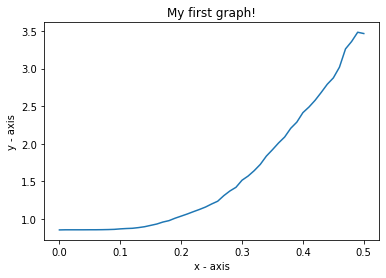

In [69]:
# x axis values
x = [i[0] for i in vary_threshold_result]
# corresponding y axis values
y = [i[5] for i in vary_threshold_result]
 
# plotting the points
plt.plot(x, y)
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
 
# giving a title to my graph
plt.title('My first graph!')
 
# function to show the plot
plt.show()

In [82]:
difference = []
for i in range(len(vary_threshold_result)-1, 0, -1):
    if (vary_threshold_result[i][3]/(vary_threshold_result[i][3]+vary_threshold_result[i][1]))>= 0.05:
        continue
    tmp = []
    tmp.append(i)
    tmp.append(vary_threshold_result[i][5] - vary_threshold_result[i-1][5])
    difference.append(tmp)

In [83]:
difference

[[21, 0.02814055681888017],
 [20, 0.027795857353341002],
 [19, 0.03241714759449321],
 [18, 0.018704681879634144],
 [17, 0.026259257012095638],
 [16, 0.017978942672609133],
 [15, 0.01783203303449854],
 [14, 0.011769464884231695],
 [13, 0.009218439532808542],
 [12, 0.003172526893266414],
 [11, 0.004783650716342014],
 [10, 0.006422800526268313],
 [9, 0.002682768758247911],
 [8, 0.0016016330192631933],
 [7, 0.0009733755219916151],
 [6, 0.0],
 [5, 0.0005309482457036552],
 [4, 0.0],
 [3, 0.0],
 [2, 0.0],
 [1, 0.00158888981535521]]

In [84]:
sorted(difference,key=lambda l:l[1], reverse=True)

[[19, 0.03241714759449321],
 [21, 0.02814055681888017],
 [20, 0.027795857353341002],
 [17, 0.026259257012095638],
 [18, 0.018704681879634144],
 [16, 0.017978942672609133],
 [15, 0.01783203303449854],
 [14, 0.011769464884231695],
 [13, 0.009218439532808542],
 [10, 0.006422800526268313],
 [11, 0.004783650716342014],
 [12, 0.003172526893266414],
 [9, 0.002682768758247911],
 [8, 0.0016016330192631933],
 [1, 0.00158888981535521],
 [7, 0.0009733755219916151],
 [5, 0.0005309482457036552],
 [6, 0.0],
 [4, 0.0],
 [3, 0.0],
 [2, 0.0]]